## Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 2,57
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
#!pip install matplotlib-label-lines
import pandas
print(pandas.__version__)
#!pip install --upgrade pandas

1.3.5


In [2]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.49;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]
filesInfected = [
    {"filename": "Netsim-Node-Metrics-IsInfected-{log_tag}", "title": "Доля инфицированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
summInfected = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatInfected():
    for file in filesInfected:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля инфицированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summInfected.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            dataI, line_lenI = load_csv_file(f"{log_dir_path}/{filesInfected[0]['filename'].format(log_tag = log_tag['tag'])}")
                                           
            aggregated, count = aggeregate_line_perc_node(data)
            aggregatedI, count = aggeregate_line_perc_node(dataI)
            aggregated = np.array(aggregated) - np.array(aggregatedI)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    showStatInfected();

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

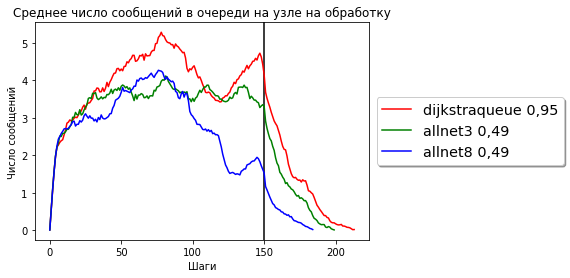

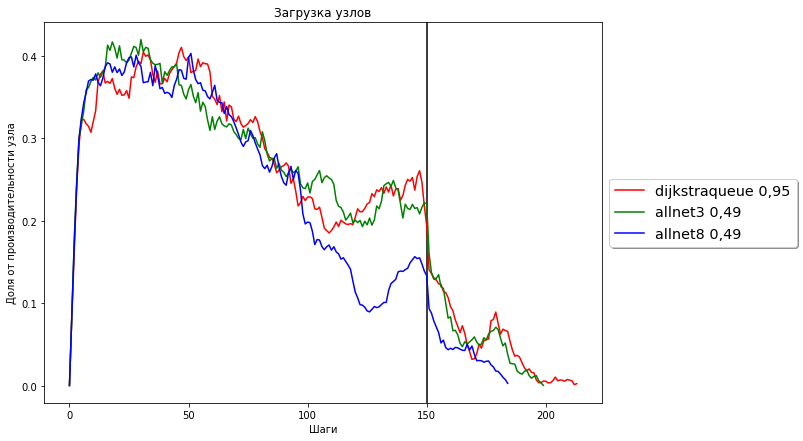

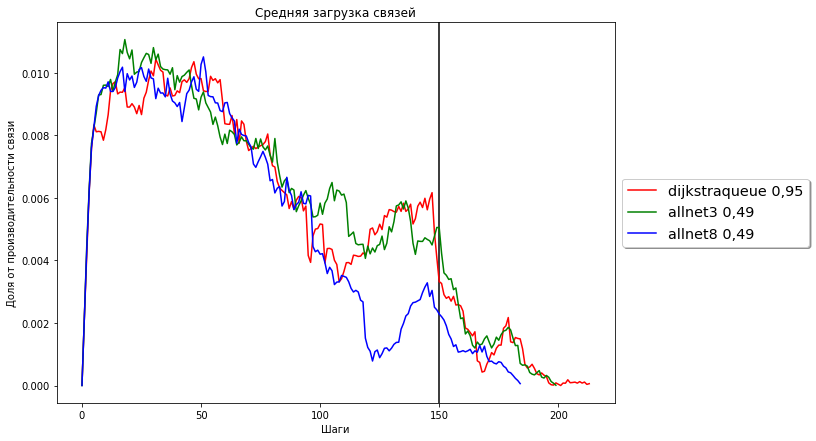

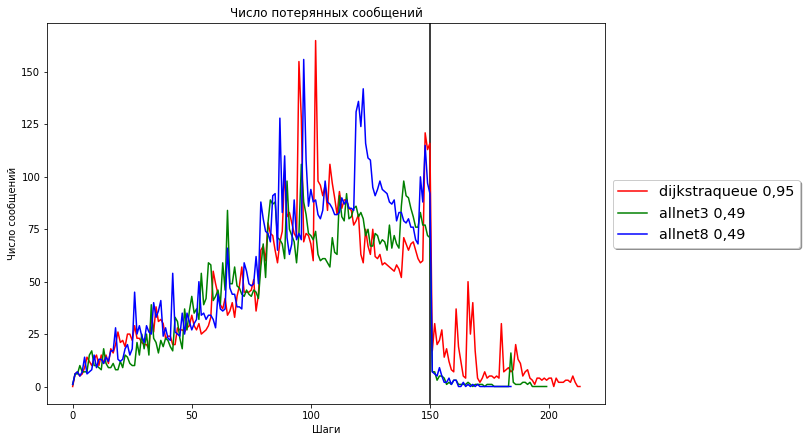

Доставлено 6661 Потеряно 55.5963% -dijkstraqueue 0,95
Доставлено 7357 Потеряно 50.9566% -allnet3 0,49
Доставлено 6197 Потеряно 58.6894% -allnet8 0,49


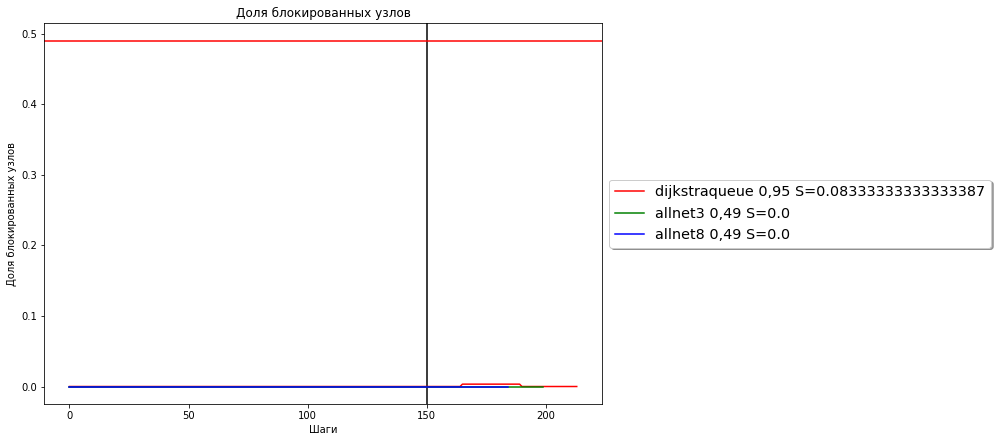

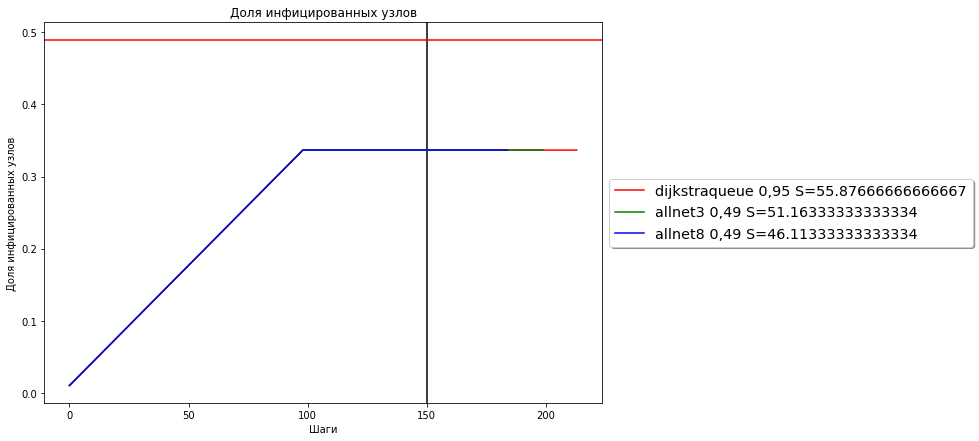

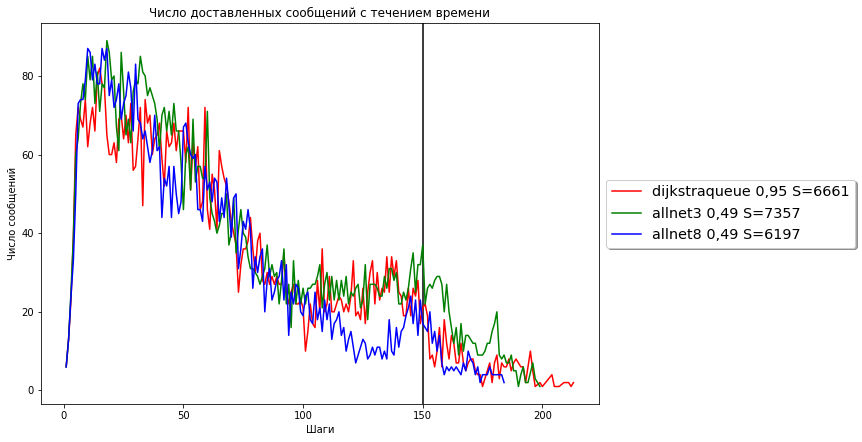

In [3]:
quantity = 100;
log_tags = [
{"tag":  "d6cc1e68-b65a-4c5e-94b4-15c19696f308", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "af2f1d27-71b3-4ea2-9e79-d25bb6a3b3e7", "label": "allnet3 0,49", "color": "green"},
{"tag":  "2e787cac-6679-4bb3-8c55-00f9dac2f103", "label": "allnet8 0,49", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();


<strong>Quantity 500 </strong>

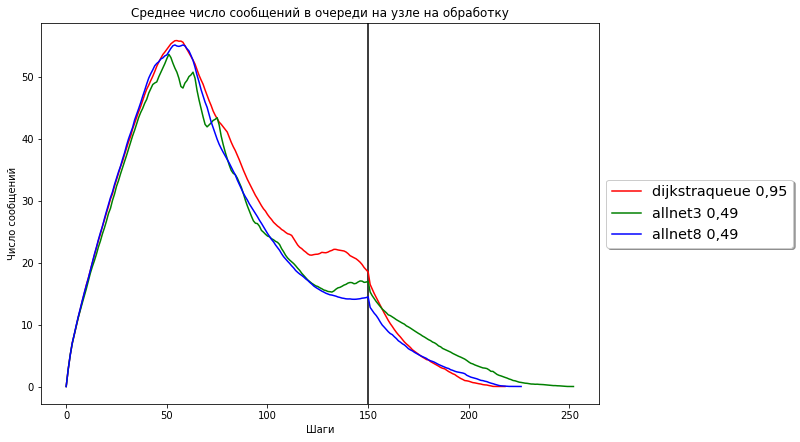

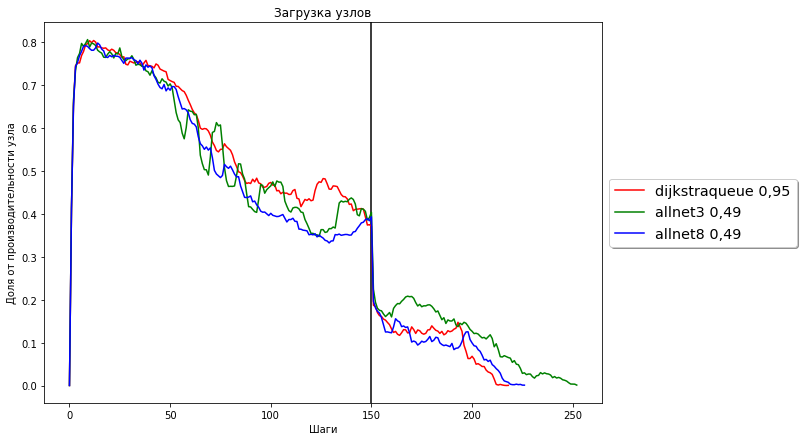

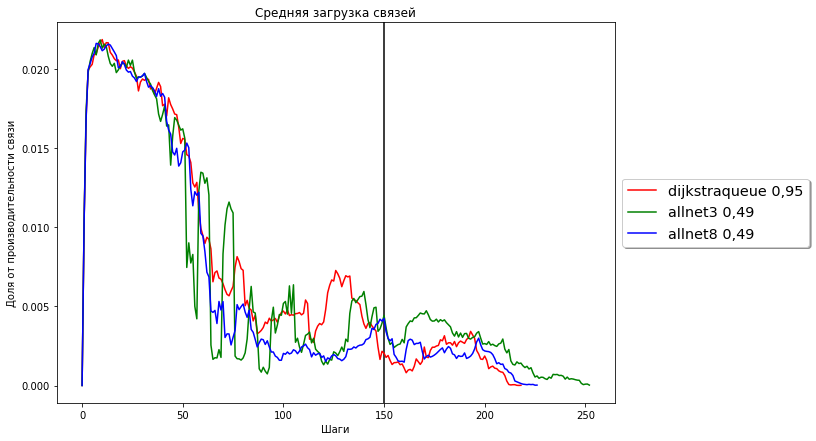

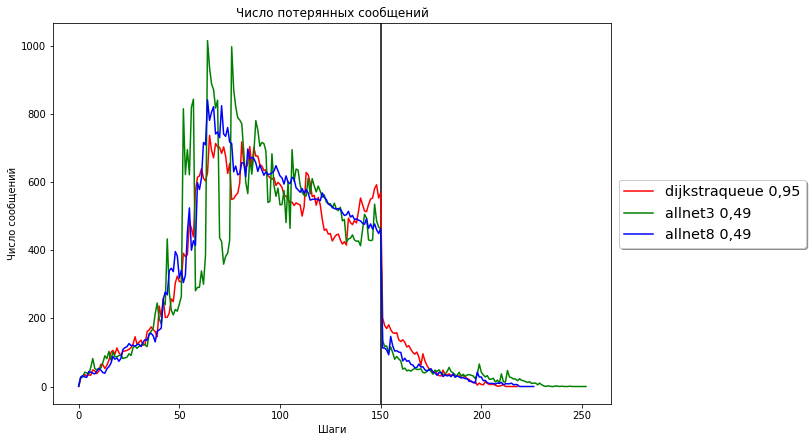

Доставлено 8542 Потеряно 88.6108% -dijkstraqueue 0,95
Доставлено 7590 Потеряно 89.8801% -allnet3 0,49
Доставлено 7061 Потеряно 90.5855% -allnet8 0,49


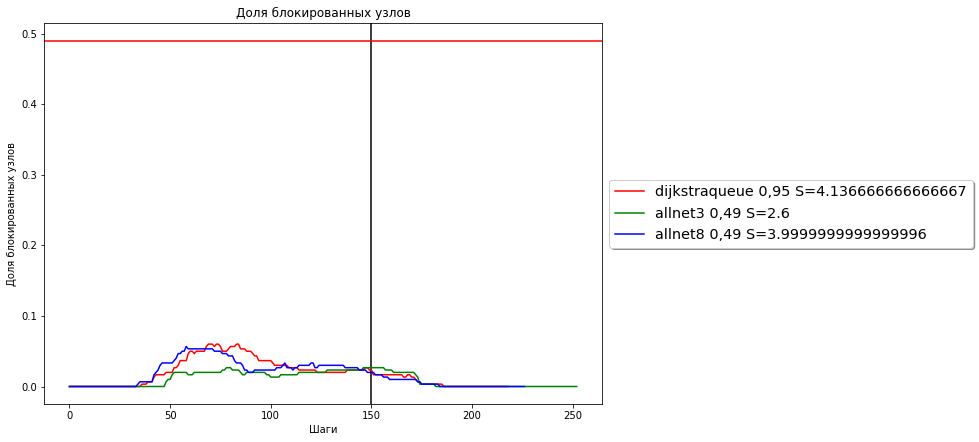

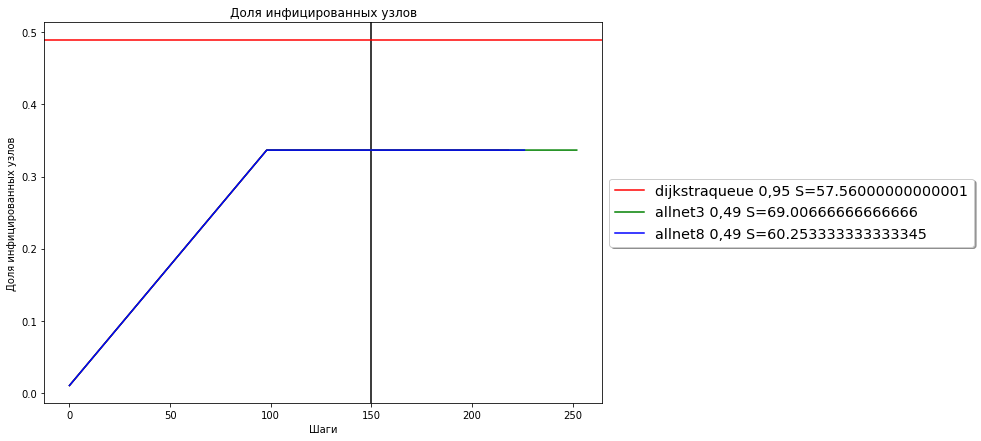

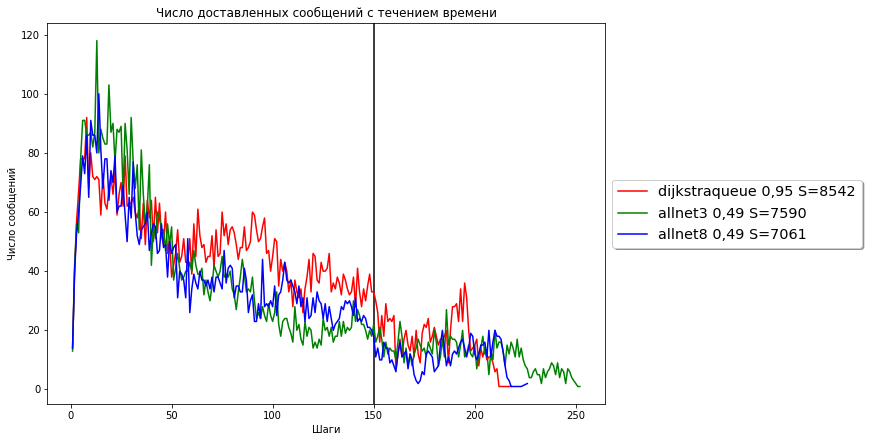

In [4]:
quantity = 500;
log_tags = [
{"tag":  "3bb8f0d8-74ad-46cf-a34a-4f124aff7fb4", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "4e744572-1aff-4215-86fa-6a6d7c0dacb0", "label": "allnet3 0,49", "color": "green"},
{"tag":  "f973fcbe-f96f-4e8d-b722-b1a470f5ce8c", "label": "allnet8 0,49", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

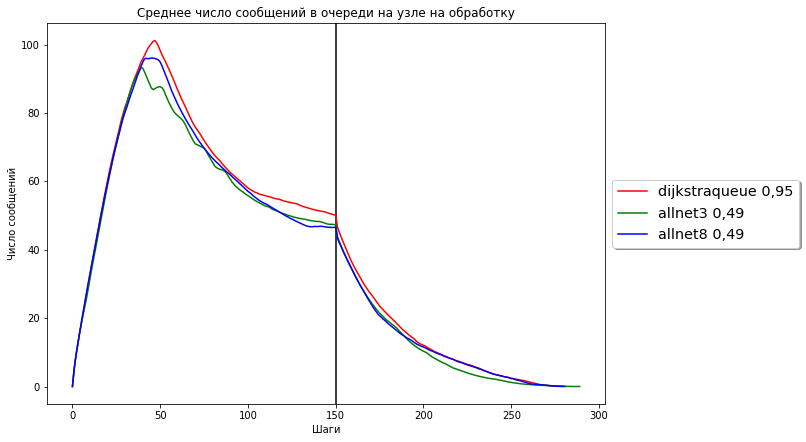

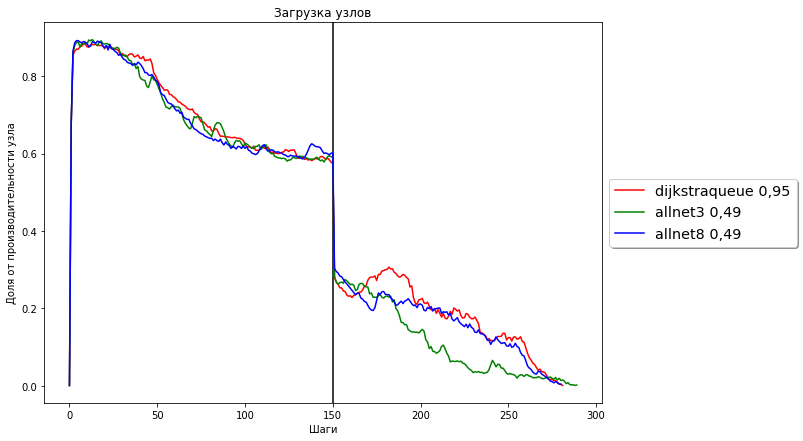

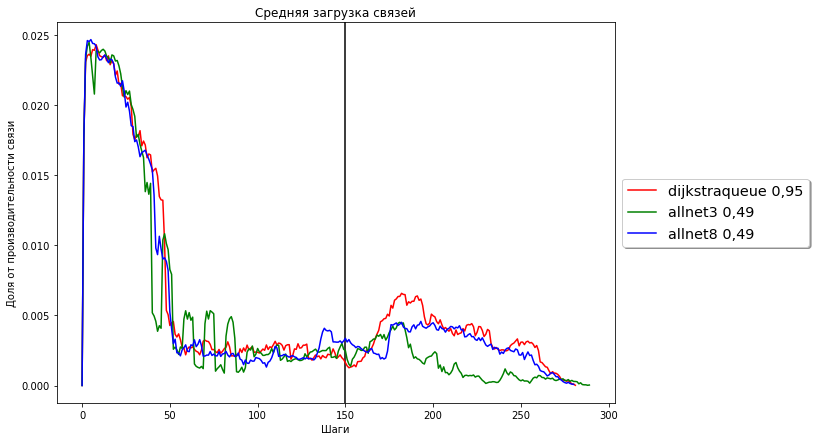

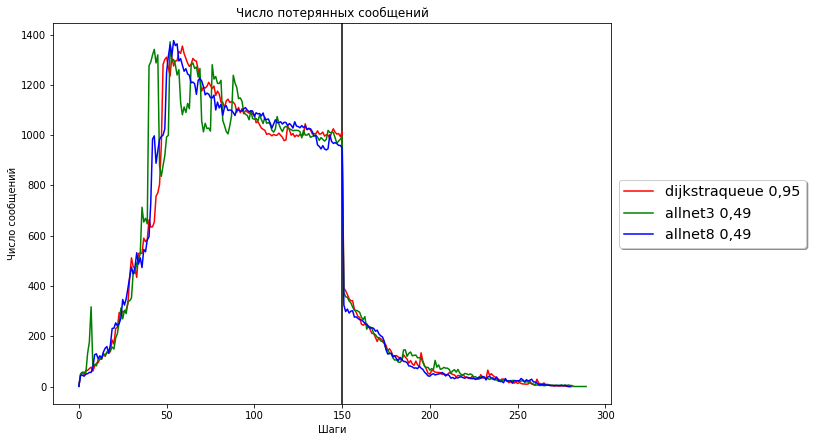

Доставлено 8842 Потеряно 94.1054% -dijkstraqueue 0,95
Доставлено 7225 Потеряно 95.1834% -allnet3 0,49
Доставлено 9109 Потеряно 93.9274% -allnet8 0,49


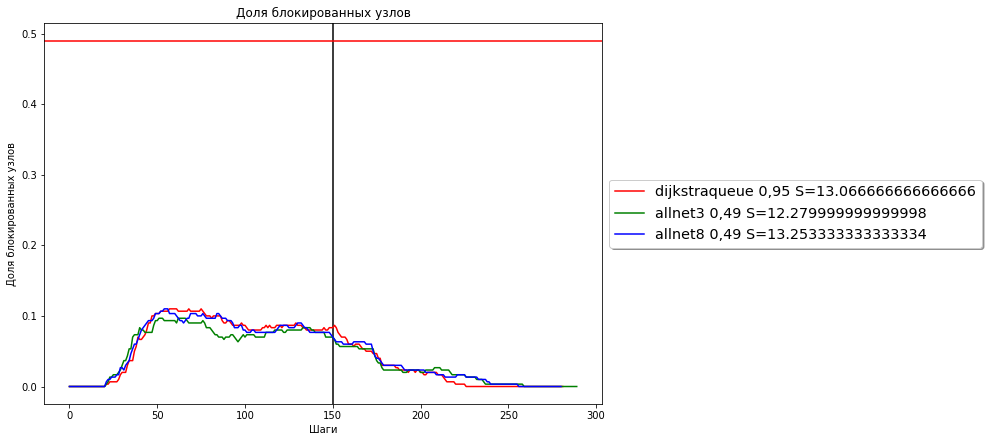

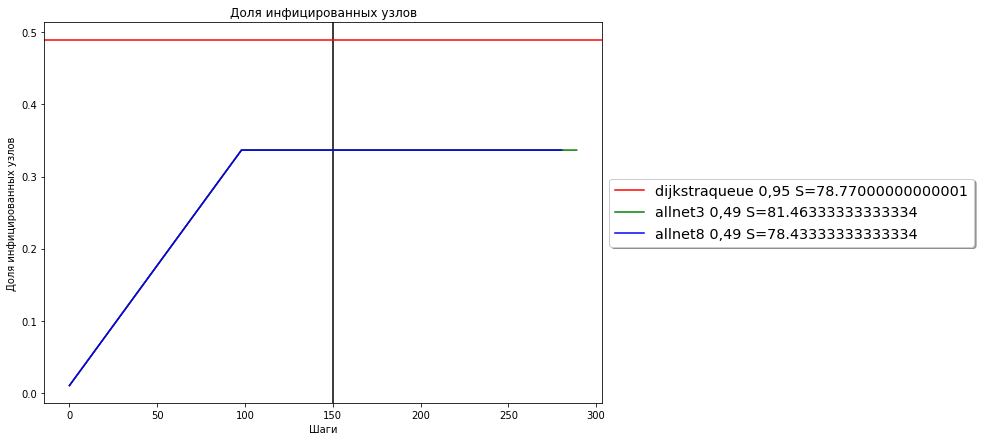

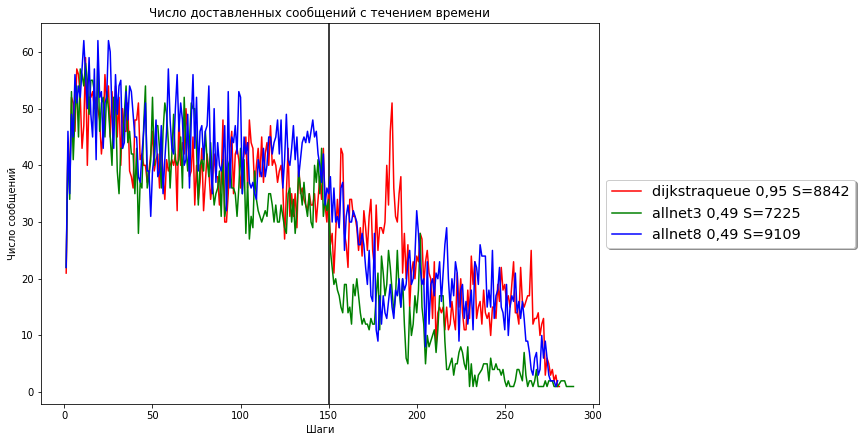

In [5]:
quantity = 1000;
log_tags = [
{"tag":  "dc3c204a-50a9-4a1d-8ea8-f886db74d2d8", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "1f950d2f-39cc-4dc2-a8a5-bf1792eb5cdf", "label": "allnet3 0,49", "color": "green"},
{"tag":  "d4b1d9a0-124b-4a1e-927c-aac82b0167ce", "label": "allnet8 0,49", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();


<strong>Quantity 1500 </strong>

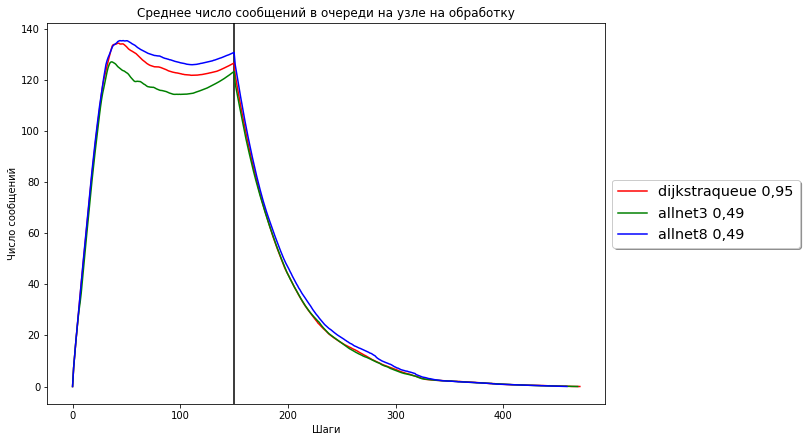

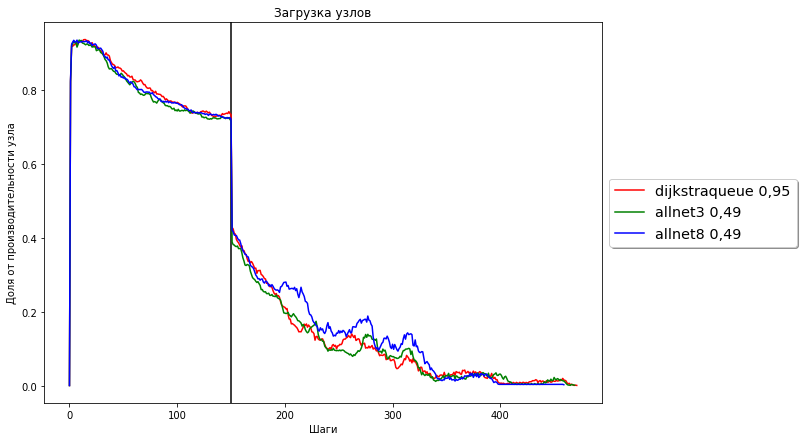

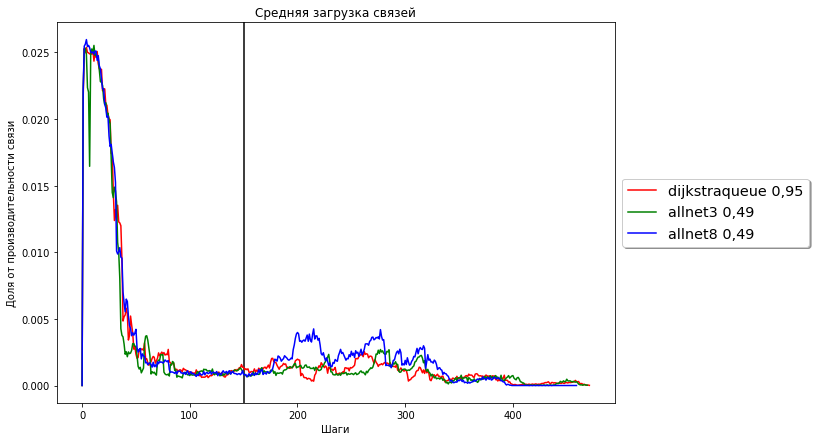

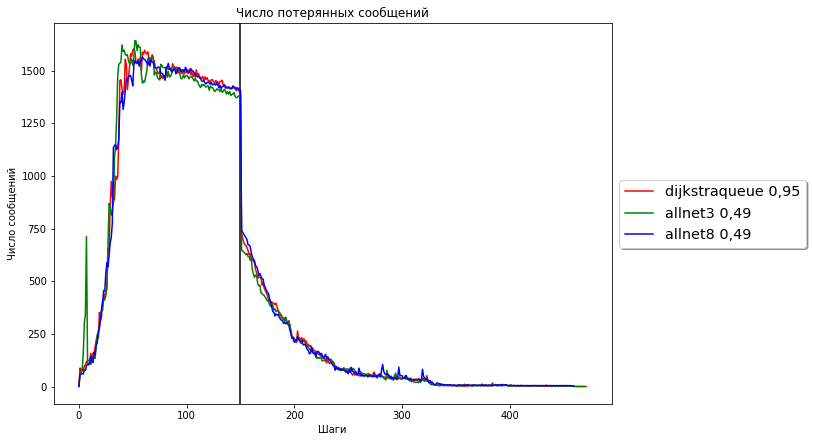

Доставлено 7253 Потеряно 96.7765% -dijkstraqueue 0,95
Доставлено 7527 Потеряно 96.6547% -allnet3 0,49
Доставлено 8135 Потеряно 96.3845% -allnet8 0,49


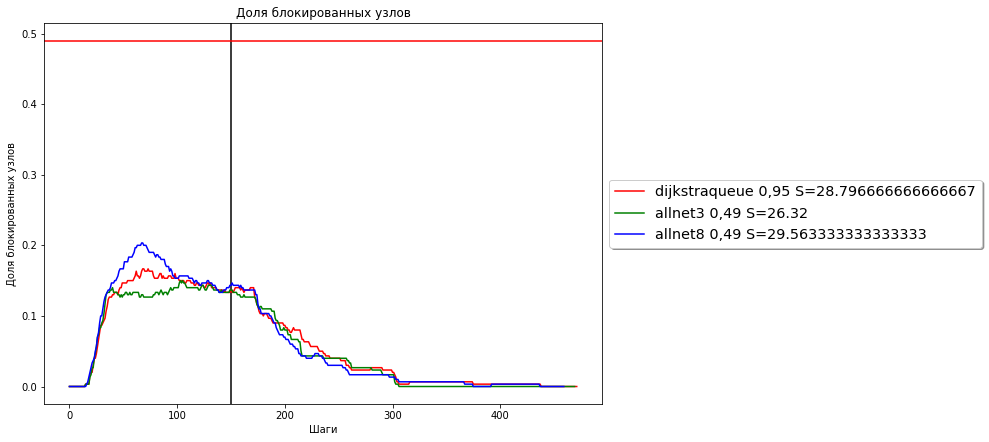

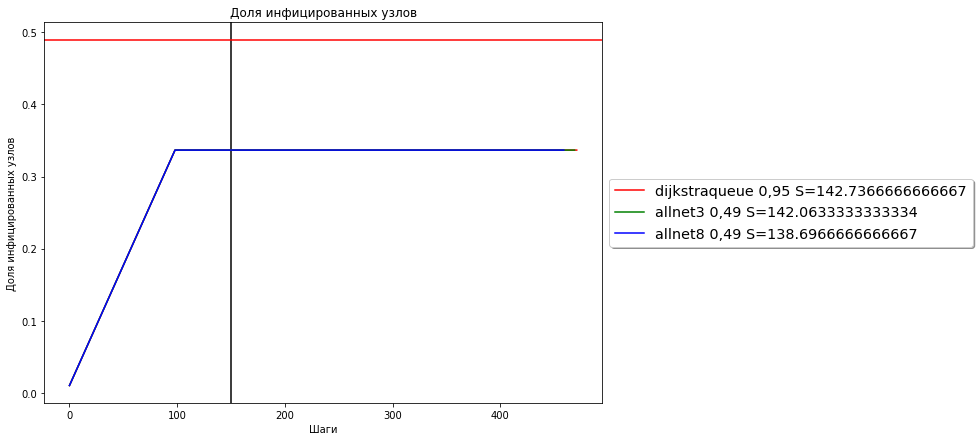

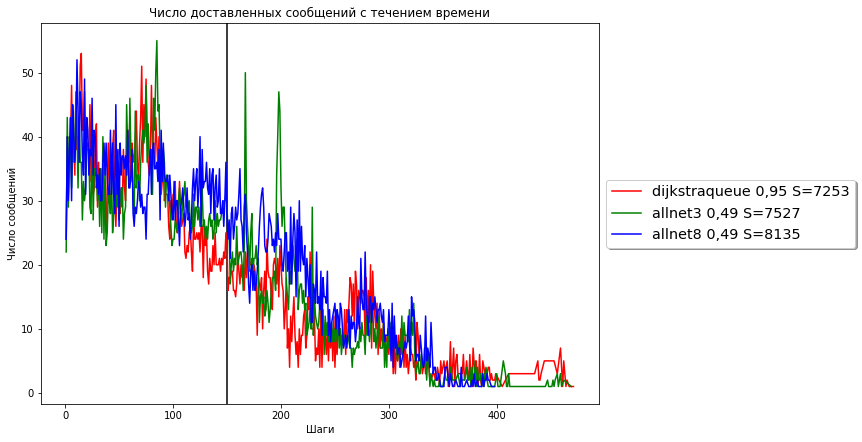

In [6]:
quantity = 1500;
log_tags = [
{"tag":  "4f8d10c7-fd49-45d2-a126-f8bb466647b6", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "7541013b-343a-4452-9543-25bbc07449f2", "label": "allnet3 0,49", "color": "green"},
{"tag":  "2d12f654-2727-43e2-8659-0278cb788dce", "label": "allnet8 0,49", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();


Доставлено 7493 Потеряно 83.3493% -dijkstraqueue 0,95
Доставлено 8059 Потеряно 82.0915% -allnet3 0,49
Доставлено 8733 Потеряно 80.5938% -allnet8 0,49


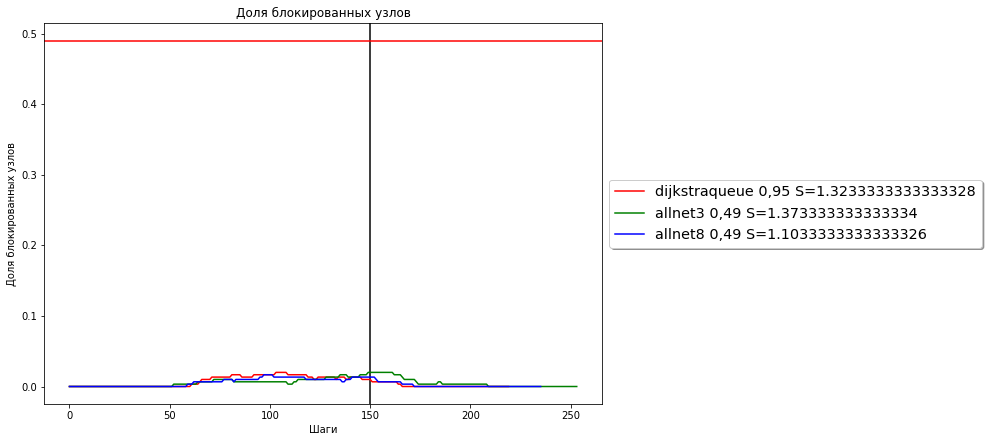

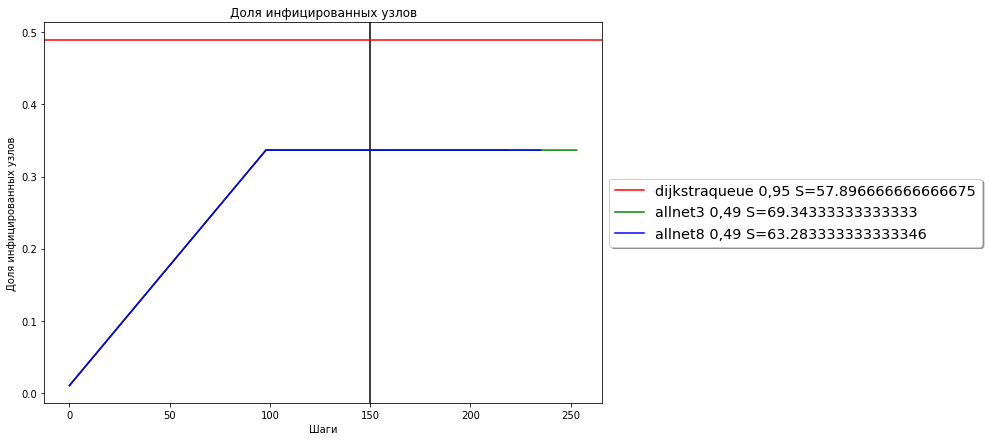

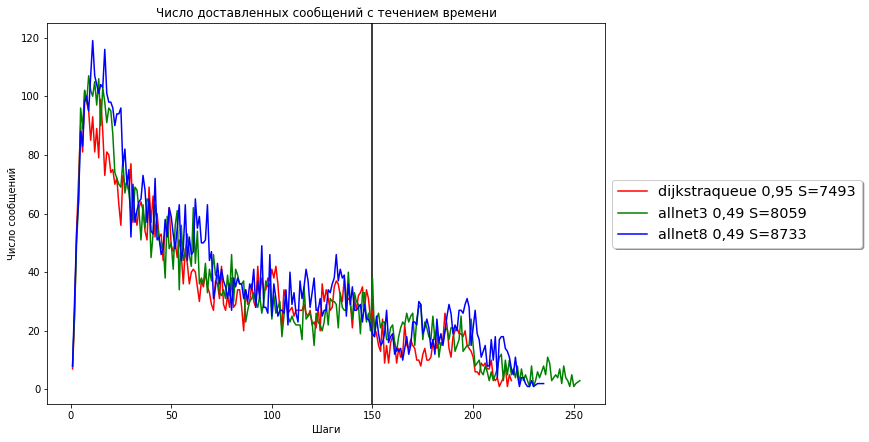

Доставлено 8699 Потеряно 91.7153% -dijkstraqueue 0,95
Доставлено 7549 Потеряно 92.8105% -allnet3 0,49
Доставлено 7066 Потеряно 93.2705% -allnet8 0,49


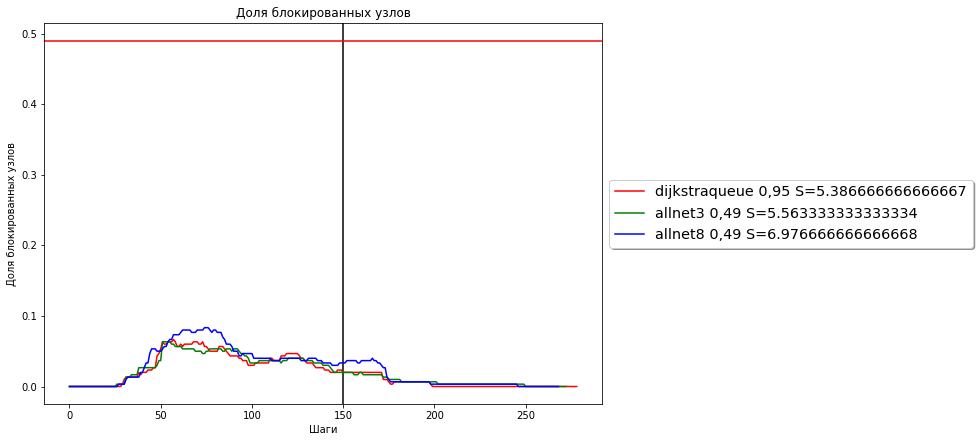

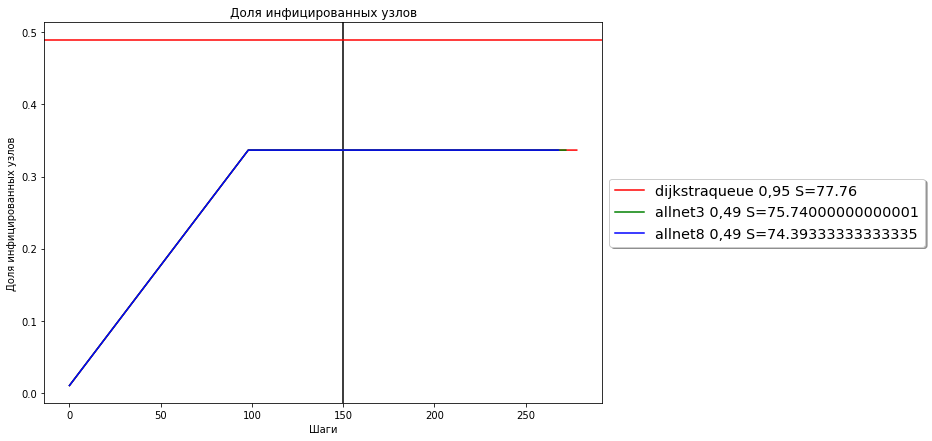

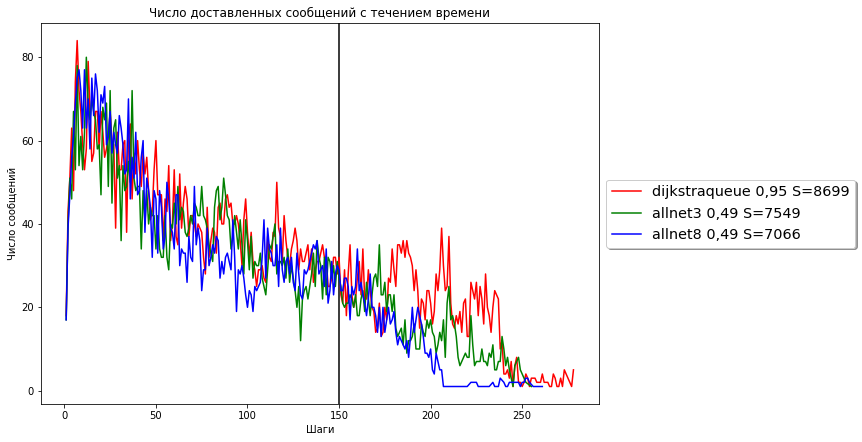

Доставлено 7786 Потеряно 94.2326% -dijkstraqueue 0,95
Доставлено 8217 Потеряно 93.9134% -allnet3 0,49
Доставлено 7354 Потеряно 94.5526% -allnet8 0,49


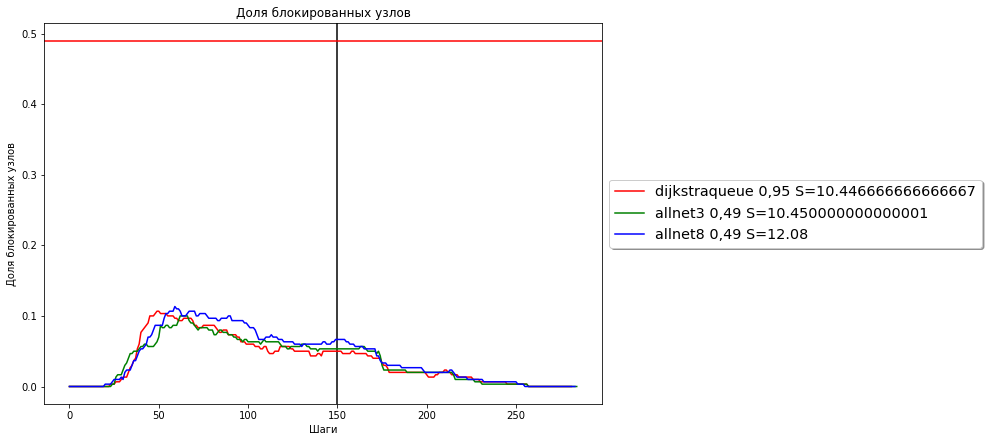

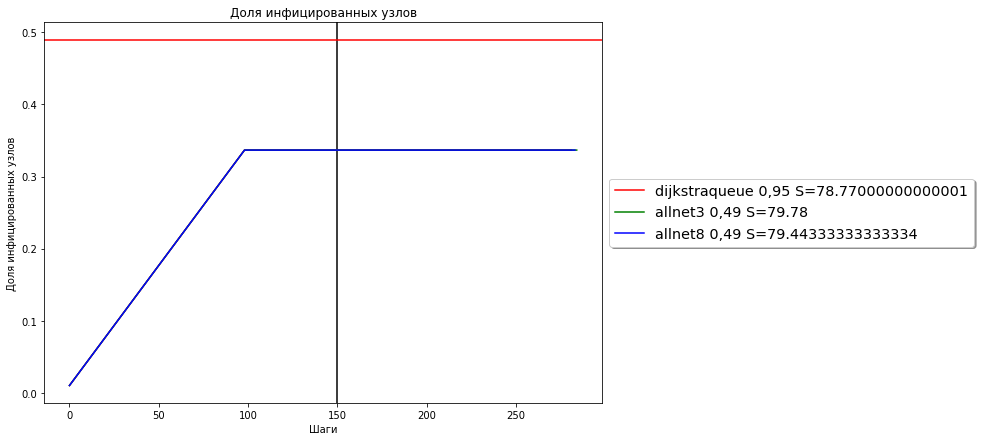

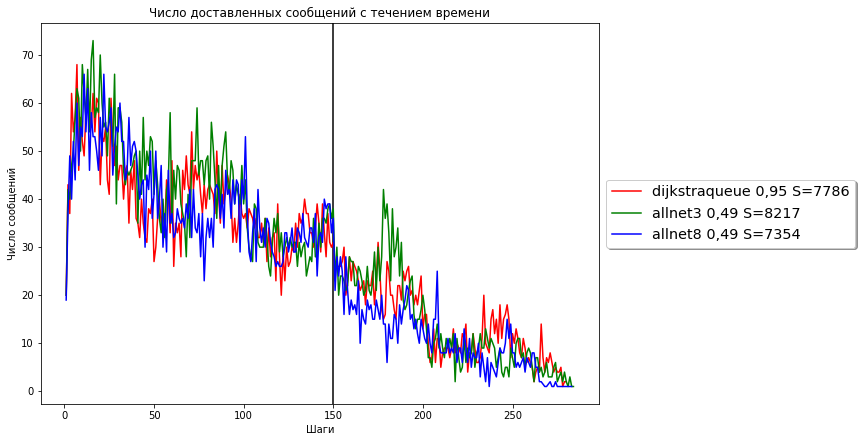

Доставлено 8156 Потеряно 95.8175% -dijkstraqueue 0,95
Доставлено 6698 Потеряно 96.5651% -allnet3 0,49
Доставлено 7465 Потеряно 96.1718% -allnet8 0,49


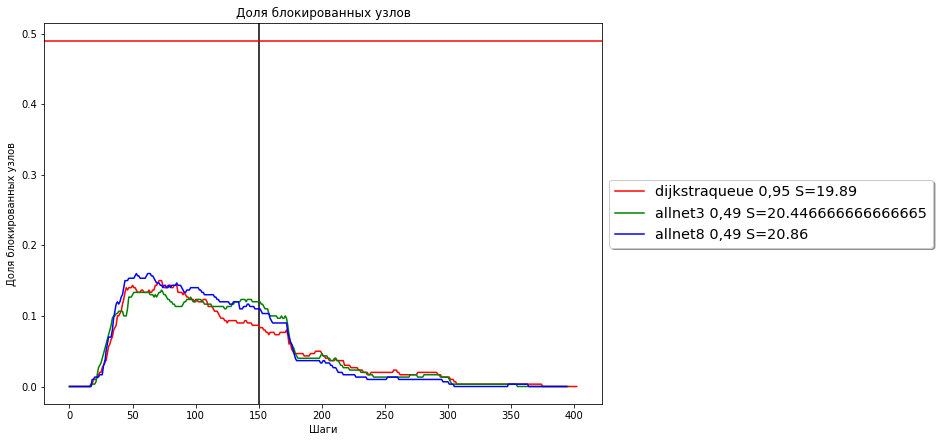

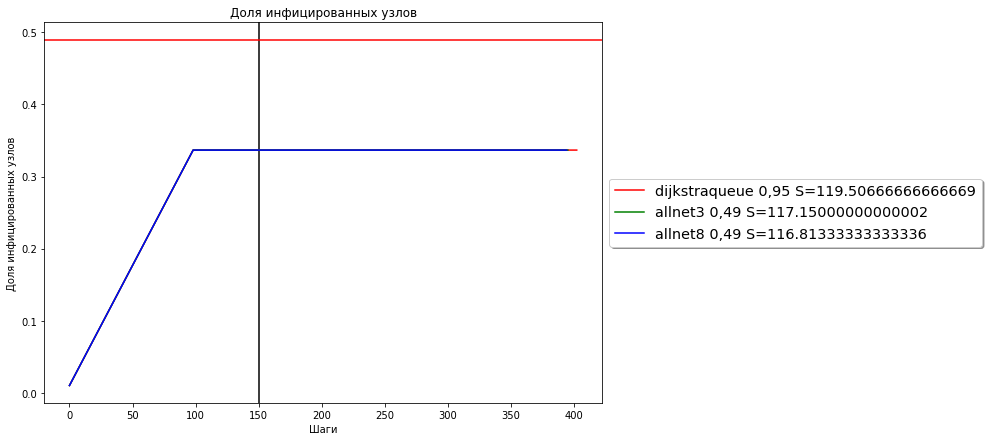

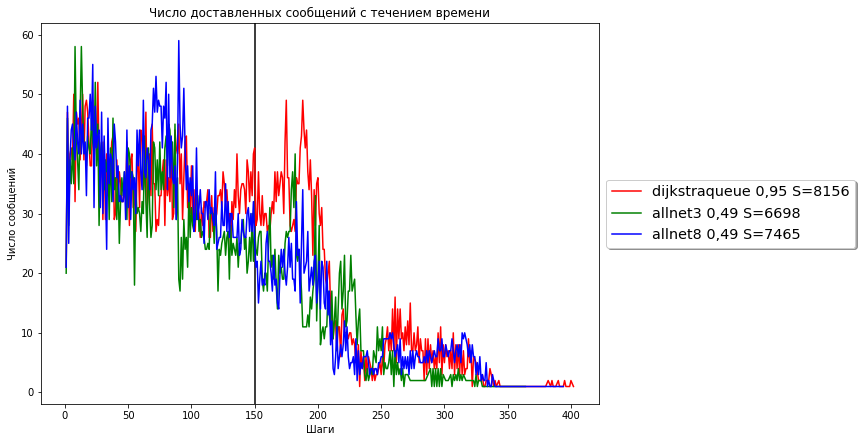

In [7]:
quantity = 300;
log_tags = [
{"tag":  "525bcf16-7942-41eb-9479-8e481c6fe20c", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "cfe927c0-26ae-44a9-bfa0-92569ea07369", "label": "allnet3 0,49", "color": "green"},
{"tag":  "33cc38ba-0a20-444f-b9ab-b164f2aab780", "label": "allnet8 0,49", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 700;
log_tags = [
{"tag":  "597b72fe-75a0-4410-8aa4-9682844b6a76", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "045bb4e2-268d-499f-9e16-2915957c8abf", "label": "allnet3 0,49", "color": "green"},
{"tag":  "69c803c1-59a9-4176-9103-f2879b959bed", "label": "allnet8 0,49", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 900;
log_tags = [
{"tag":  "7492fea5-f6e5-43b8-aab9-fda7ba0a4de5", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "2d21e6fd-2dbd-4ab8-8edc-a4e07ab274c0", "label": "allnet3 0,49", "color": "green"},
{"tag":  "89a46f08-b191-4bfc-b6d1-a0f0442e0bc5", "label": "allnet8 0,49", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 1300;
log_tags = [
{"tag":  "a5463ec5-2e3a-423d-b987-45defc737d35", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "a82610bf-bf81-46a8-b15b-cceccfeb77c7", "label": "allnet3 0,49", "color": "green"},
{"tag":  "b36a396b-c070-4ba2-8743-63bc30369579", "label": "allnet8 0,49", "color": "blue"},
]
showStatBlocked();
showStatMessage();

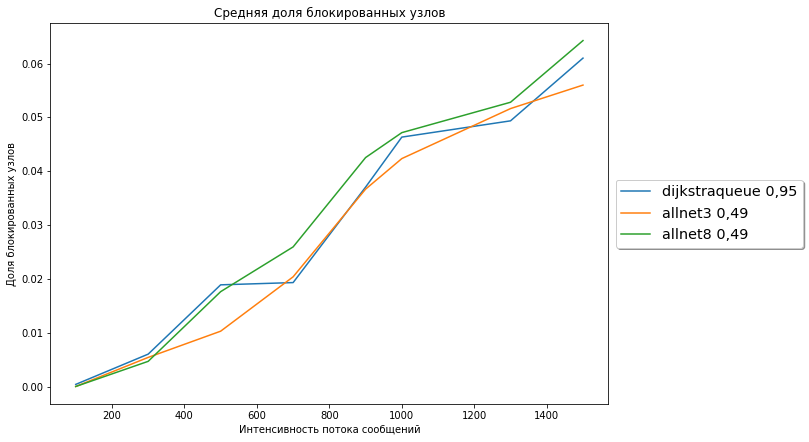

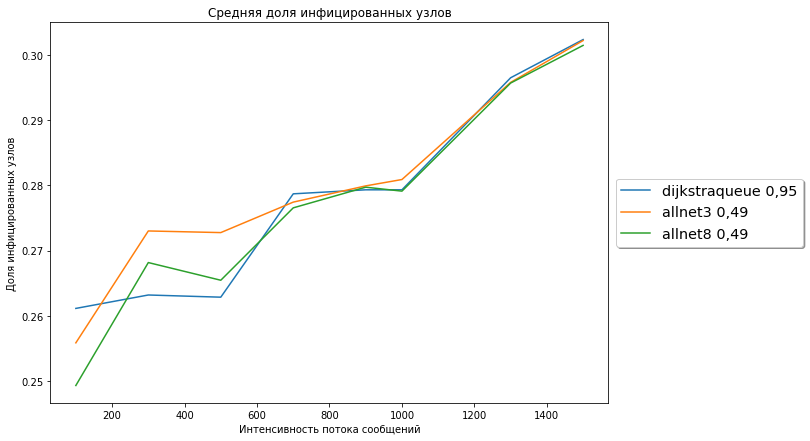

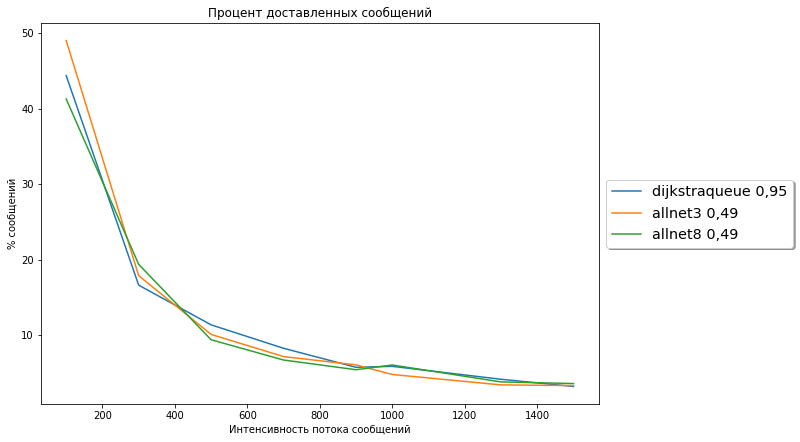

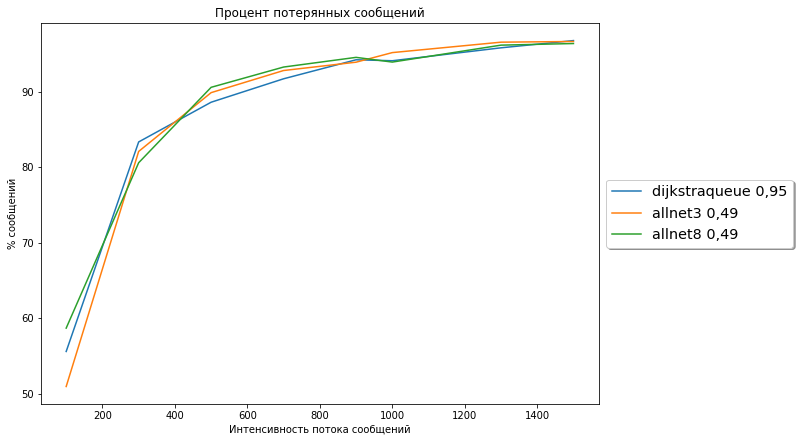

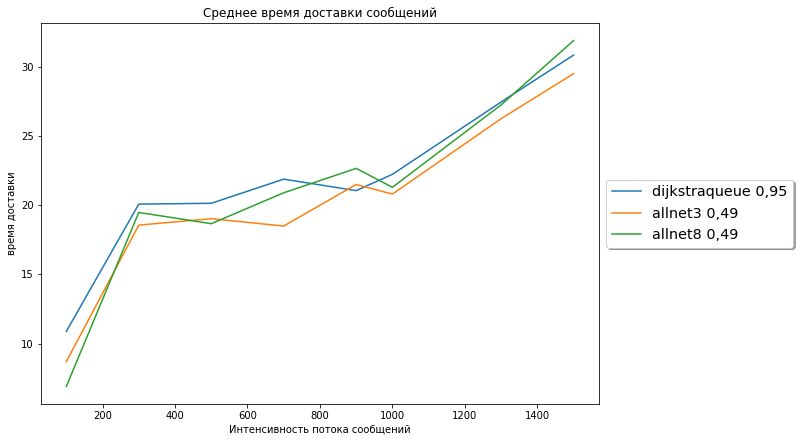

In [8]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

summInfected.sort_index(inplace=True)
axs = summInfected.plot()
axs.set_title("Средняя доля инфицированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля инфицированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [9]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())
print("")
print(summInfected.mean().to_string())

dijkstraqueue 0,95    0.029793
allnet3 0,49          0.027838
allnet8 0,49          0.031876

dijkstraqueue 0,95    87.525452
allnet3 0,49          87.256920
allnet8 0,49          88.021933

dijkstraqueue 0,95    21.808296
allnet3 0,49          20.343432
allnet8 0,49          21.117789

dijkstraqueue 0,95    0.277927
allnet3 0,49          0.279743
allnet8 0,49          0.276937
